In [1]:
from statsmodels.tsa.stattools import adfuller
import polars as pl
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
import numpy as np

In [2]:
df = pl.read_parquet("/Users/guillemlopezcolomer/Desktop/traffic_prediction_tfg/data/processed/dataset_imputed_clean.parquet")
df.head()

idTram,timestamp,estatActual,estatPrevist,is_gap,gap_type,estatActual_imputed
i32,datetime[μs],i8,i8,bool,str,bool
1,2023-12-01 00:00:00,1,0,false,null,true
1,2023-12-01 00:05:00,1,null,true,"""short""",true
1,2023-12-01 00:10:00,1,null,true,"""short""",true
1,2023-12-01 00:15:00,1,1,false,null,true
1,2023-12-01 00:20:00,1,0,true,"""short""",true


In [3]:
series = df["estatActual"]
#sample = series[::5]

result = adfuller(series, maxlag=12, autolag=None, regression="c")
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -624.5822571293184
p-value: 0.0


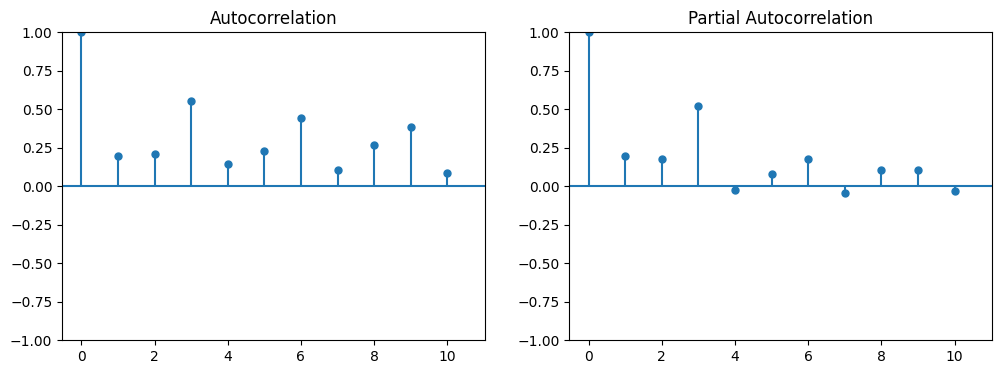

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

series = df["estatActual"].to_pandas()[::100]

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(series, lags=10, ax=ax[0])
plot_pacf(series, lags=10, ax=ax[1])
plt.show()

In [5]:
p, d, q = 3, 0, 0
sample = df["estatActual"].to_numpy()[-200_000:]

model = ARIMA(sample, order=[p, d, q])
model = ARIMA(sample, order=(3, 0, 0)).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:               200000
Model:                 ARIMA(3, 0, 0)   Log Likelihood             -148859.389
Date:                Tue, 11 Nov 2025   AIC                         297728.777
Time:                        17:58:37   BIC                         297779.807
Sample:                             0   HQIC                        297743.796
                             - 200000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1204      0.014    153.717      0.000       2.093       2.147
ar.L1          0.5199      0.001    371.865      0.000       0.517       0.523
ar.L2          0.2785      0.001    250.756      0.0

In [6]:
model_arma31 = ARIMA(sample, order=(3, 0, 1)).fit()
print(f"AIC AR(3): {model.aic:.2f}")
print(f"AIC ARMA(3,1): {model_arma31.aic:.2f}")

/Users/guillemlopezcolomer/Desktop/traffic_prediction_tfg/.venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/guillemlopezcolomer/Desktop/traffic_prediction_tfg/.venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AIC AR(3): 297728.78
AIC ARMA(3,1): 294970.68


In [7]:
print(model_arma31.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:               200000
Model:                 ARIMA(3, 0, 1)   Log Likelihood             -147479.339
Date:                Tue, 11 Nov 2025   AIC                         294970.678
Time:                        18:09:23   BIC                         295031.914
Sample:                             0   HQIC                        294988.701
                             - 200000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1211      0.018    118.567      0.000       2.086       2.156
ar.L1          1.1899      0.005    241.937      0.000       1.180       1.200
ar.L2         -0.1004      0.003    -35.955      0.0

In [9]:
split = int(len(sample) * 0.8)
train, test = sample[:split], sample[split:]

In [10]:
model = ARIMA(train, order=(3, 0, 1)).fit()
forecast = model.forecast(steps=len(test))

/Users/guillemlopezcolomer/Desktop/traffic_prediction_tfg/.venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/guillemlopezcolomer/Desktop/traffic_prediction_tfg/.venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [18]:
mae = mean_absolute_error(test, forecast)
rmse = root_mean_squared_error(test, forecast)
mape = np.mean(np.abs((test - forecast) / np.where(test == 0, np.nan, test))) * 100

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape:.2f}%")


MAE: 0.593
RMSE: 0.764
MAPE: 50.09%
